In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from tqdm import tqdm

### Rhombhus Dist: X + Y <= 1

In [2]:
rhombus_fn = lambda x, y: 0.5 * ((np.abs(x) + np.abs(y)) <= 1)
init_sample = (0, 0)
n_samples = 10_000
rand_step = lambda x: x + (np.random.rand() - 0.5)
proposed_generator = lambda x, y: (rand_step(x), rand_step(y))

In [3]:
def generate_single_sample(init_sample, proposed_generator, target_pdf):
    sample = proposed_generator(*init_sample)
    chance = min(1, target_pdf(*sample) / target_pdf(*init_sample))

    if chance < np.random.rand():
        sample = init_sample
    
    return sample


def generate_samples(n_samples, init_sample, proposed_generator, target_pdf):
    samples = []
    prev_sample = init_sample

    for _ in tqdm(range(n_samples), total=n_samples):
        sample = generate_single_sample(prev_sample, proposed_generator, target_pdf)
        samples.append(sample)
        prev_sample = samples[-1]

    return samples

In [4]:
samples = generate_samples(n_samples, init_sample, proposed_generator, rhombus_fn)

100%|██████████| 10000/10000 [00:00<00:00, 278325.13it/s]


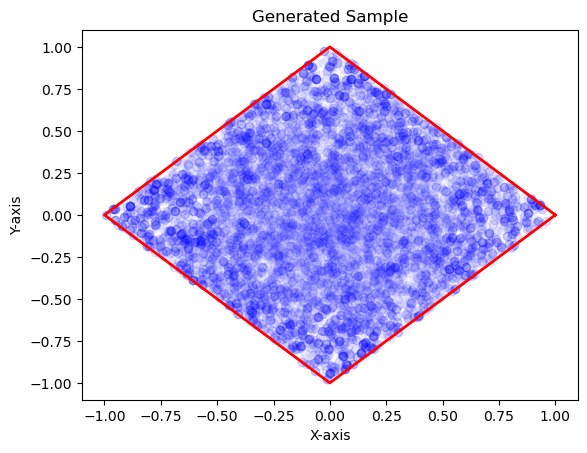

In [5]:
samples = np.array(samples)
samples_x, samples_y = samples[:,0], samples[:,1]

# Coordinates of the rhombus vertices
x = [1, 0, -1, 0, 1]
y = [0, 1, 0, -1, 0]

# Plot the rhombus edges
plt.plot(x, y, 'r-', linewidth=2)
plt.scatter(samples_x, samples_y, color='blue', marker='o', alpha=0.05)

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title(f"Generated Sample")

# Show plot
plt.show()

### Gaussian Mixture Distribution

In [6]:
weights = [0.3, 0.7]
gaussians = [(3,1.5), (-1,1)]

def gaussian_mixture_pdf(x, weights, gaussians):
    x_array = np.atleast_1d(x)
    
    pdf = np.zeros(len(x_array))
    for w, (loc, scale) in zip(weights, gaussians):
        pdf += w * st.norm.pdf(x_array, loc=loc, scale=scale)
    
    return pdf[0] if np.isscalar(x) else pdf

In [7]:
n_samples = 10_000
proposed_generator = lambda x: (np.random.normal(x, 1), )
target_pdf = lambda x: gaussian_mixture_pdf(x, weights, gaussians)
samples = generate_samples(n_samples, (0, ), proposed_generator, target_pdf)
samples = np.array(samples)[:,0]

100%|██████████| 10000/10000 [00:01<00:00, 8432.20it/s]


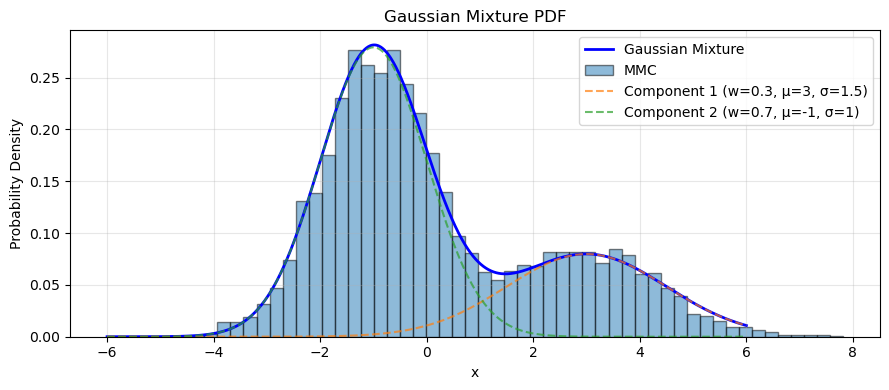

PDF value at x=-1: 0.281539


In [8]:
# Create x values for plotting
x_vals = np.linspace(-6, 6, 1000)
pdf_vals = gaussian_mixture_pdf(x_vals, weights, gaussians)

# Plot the mixture
plt.figure(figsize=(9, 4))
plt.plot(x_vals, pdf_vals, 'b-', linewidth=2, label='Gaussian Mixture')
plt.hist(samples, bins=50, density=True, alpha=0.5, label='MMC', edgecolor='black')

# Optionally plot individual components
for i, (w, (loc, scale)) in enumerate(zip(weights, gaussians)):
    component_pdf = w * st.norm.pdf(x_vals, loc=loc, scale=scale)
    plt.plot(x_vals, component_pdf, '--', alpha=0.7, label=f'Component {i+1} (w={w}, μ={loc}, σ={scale})')

# Mark the point at x=-1
y_at_minus1 = gaussian_mixture_pdf(-1, weights, gaussians)

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian Mixture PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the value at x=-1
print(f"PDF value at x=-1: {y_at_minus1:.6f}")